In [1]:
# This notebook is for DUP evaluation
# I have developed skeleton code for the evaluation of DUP using LAST and HG2-T2T v0.9 data
# This notebook is for transition from HG2-T2T v0.9 to HG2-T2T v1.0 and LAST to minimap2
# Additionally, I want to incorporate evaluating DUP+DEL cases in T2T-ACE
# TODO: 1. Transit initial analyzing code for DUP evaluation to avoid repetitive code for the same function and add more functions specific to DUP evaluation DONE
# TODO: 2. Develop code for DUP+DEL evaluation DONE
# TODO: 3. Evaluate DUP+DEL cases DONE
# TODO: 4. Evaluate DUP+DEL cases that are not working as expected 12, 13


In [2]:
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
import T2T_ACE.alignment_utilities as au 
import T2T_ACE.validator as v
import T2T_ACE.alignment_visualization_utilities as avu
import importlib
import pandas as pd
import T2T_ACE.genomic_queries as gq
import T2T_ACE.interval_parsing as ip
import numpy as np
import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# Update the reference genomes to local path
class ReferenceLocations:
        hg002t2t = "/Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta"
        chm13 = "/Users/gaoyueya/Documents/Reference_Genome/chm13v2.0.fa.gz"
        hg38 = "/Users/gaoyueya/Documents/Reference_Genome/Homo_sapiens_assembly38.fasta"

In [4]:
# Load HG002 T2T reference
hg002t2t = au.load_reference(ReferenceLocations.hg002t2t)
# Load hg38 reference
hg38 = au.load_reference(ReferenceLocations.hg38)

INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta
INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/Homo_sapiens_assembly38.fasta


# DEL within DUP cases

In [5]:
HG2_DRAGEN_cnv_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1639/DRAGEN4_2_4_visualization/DRAGEN_Output/NA24385.cnv_sv.vcf"
def read_vcf(vcf_path):
    df = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    return df

In [6]:
HG2_DRAGEN_cnv = read_vcf(HG2_DRAGEN_cnv_path)
HG2_DRAGEN_pass_cnv = HG2_DRAGEN_cnv[HG2_DRAGEN_cnv['FILTER']=='PASS']
HG2_DRAGEN_pass_cnv.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,chr1,789481,DRAGEN:GAIN:chr1:789482-224014488,N,<DUP>,150,PASS,END=224014488;SVTYPE=DUP;SVLEN=223225007;CIPOS...,GT:FT:GQ:PL:PR:SR,"0/1:PASS:602:652,0,663:11,5:33,21"
1,chr1,934321,DRAGEN:LOSS:chr1:934322-934937,N,<DEL>,150,PASS,END=934937;SVTYPE=DEL;SVLEN=-616;CIGAR=1M616D;...,GT:FT:GQ:PL:PR:SR,"1/1:PASS:55:924,58,0:1,2:0,24"
3,chr1,1934923,DRAGEN:LOSS:chr1:1934924-1935584,N,<DEL>,150,PASS,END=1935584;SVTYPE=DEL;SVLEN=-661;CIGAR=1M661D...,GT:FT:GQ:PL:PR:SR,"0/1:PASS:503:553,0,707:24,1:38,18"
4,chr1,1934989,DRAGEN:LOSS:chr1:1934990-1935584,N,<DEL>,150,PASS,END=1935584;SVTYPE=DEL;SVLEN=-595;CIGAR=1M595D...,GT:FT:GQ:PL:PR:SR,"0/1:PASS:426:476,0,746:21,2:42,16"
5,chr1,2122128,DRAGEN:LOSS:chr1:2122129-2124374,N,<DEL>,150,PASS,"END=2124374;SVTYPE=DEL;SVLEN=-2246;CIPOS=0,10;...",GT:FT:GQ:PL:PR:SR,"0/1:PASS:556:606,0,635:34,2:21,20"


In [7]:
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
DEL_pass_intervals = []
DUP_pass_intervals = []
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    if row['ALT'] == '<DEL>':
        DEL_pass_intervals.append(interval)
    elif row['ALT'] == '<DUP>':
        DUP_pass_intervals.append(interval)
print('HG2 DEL intervals:',len(DEL_pass_intervals))
print('HG2 DUP intervals:',len(DUP_pass_intervals))

HG2 DEL intervals: 996
HG2 DUP intervals: 115


In [8]:
# Remove the DUP interval that is a known FP
DUP_pass_intervals.remove("chr1:789481-224014488") 

In [9]:
# Collect all the DEL within DUP intervals
del_within_dup_list = []
dup_within_del_list = []
for del_interval in DEL_pass_intervals:
    del_chrom = del_interval.split(':')[0]
    del_pos = int(del_interval.split(':')[1].split('-')[0])
    del_end = int(del_interval.split(':')[1].split('-')[1])
    for dup_interval in DUP_pass_intervals: 
        dup_chrom = dup_interval.split(':')[0]
        dup_pos = int(dup_interval.split(':')[1].split('-')[0])
        dup_end = int(dup_interval.split(':')[1].split('-')[1])
        if del_chrom == dup_chrom:
            if del_pos >= dup_pos and del_end <= dup_end:
                print('DEL within DUP:', del_interval, dup_interval)
                del_within_dup_list.append([del_interval, dup_interval])
            elif dup_pos >= del_pos and dup_end <= del_end:
                print('DUP within DEL:', del_interval, dup_interval)
                dup_within_del_list.append([del_interval, dup_interval])

DEL within DUP: chr1:13235347-13240700 chr1:13225212-13247040
DEL within DUP: chr2:89815283-89817768 chr2:89795582-89851643
DEL within DUP: chr9:40902057-40902568 chr9:40867979-41021827
DEL within DUP: chr14:19907852-19911319 chr14:19725013-19956413
DEL within DUP: chr16:34176544-34178323 chr16:34163911-34184726
DEL within DUP: chr16:34182721-34183891 chr16:34163911-34184726
DUP within DEL: chr17:21984528-21988903 chr17:21986665-21987716
DEL within DUP: chr17:22139255-22143674 chr17:22130211-22156606
DEL within DUP: chr17:45613816-46277010 chr17:45578419-46289344
DUP within DEL: chr17:45613816-46277010 chr17:46205463-46208952
DEL within DUP: chr17:46237501-46238225 chr17:45578419-46289344
DEL within DUP: chr17:46237501-46238225 chr17:46135409-46292238
DEL within DUP: chr17:46237501-46238225 chr17:46135409-46282220
DEL within DUP: chr17:46277763-46282220 chr17:45578419-46289344
DEL within DUP: chr17:46277763-46282220 chr17:46135409-46292238
DEL within DUP: chr17:46277763-46282220 chr17:

In [10]:
print('HG2 DEL within DUP:', len(del_within_dup_list))
print('HG2 DUP within DEL:', len(dup_within_del_list))

HG2 DEL within DUP: 17
HG2 DUP within DEL: 4


In [11]:
del_within_dup_list

[['chr1:13235347-13240700', 'chr1:13225212-13247040'],
 ['chr2:89815283-89817768', 'chr2:89795582-89851643'],
 ['chr9:40902057-40902568', 'chr9:40867979-41021827'],
 ['chr14:19907852-19911319', 'chr14:19725013-19956413'],
 ['chr16:34176544-34178323', 'chr16:34163911-34184726'],
 ['chr16:34182721-34183891', 'chr16:34163911-34184726'],
 ['chr17:22139255-22143674', 'chr17:22130211-22156606'],
 ['chr17:45613816-46277010', 'chr17:45578419-46289344'],
 ['chr17:46237501-46238225', 'chr17:45578419-46289344'],
 ['chr17:46237501-46238225', 'chr17:46135409-46292238'],
 ['chr17:46237501-46238225', 'chr17:46135409-46282220'],
 ['chr17:46277763-46282220', 'chr17:45578419-46289344'],
 ['chr17:46277763-46282220', 'chr17:46135409-46292238'],
 ['chr17:46277763-46282220', 'chr17:46135409-46282220'],
 ['chr19:24390753-24391430', 'chr19:24330002-24405855'],
 ['chr19:27380261-27382482', 'chr19:27346020-27398099'],
 ['chr19:27390844-27391527', 'chr19:27346020-27398099']]

## Hand check another DEL within DUP
## DEL: 'chr2:89815283-89817768' DUP: 'chr2:89795582-89851643'

In [13]:
# First Examine this DUP, see if it is a real DUP
# chr2:89795582-89851643
v.align_interval("chr2:89795582-89851643", ReferenceLocations.hg38, hg38, hg002t2t) 

([['chr2:89795581-89851643', 1]],
 [['chr2_MATERNAL:90016247-90073488', 1],
  ['chr2_PATERNAL:89941620-89998824', 1],
  ['chr2_PATERNAL:88965829-89020444', -1],
  ['chr2_MATERNAL:89046296-89104490', -1]])

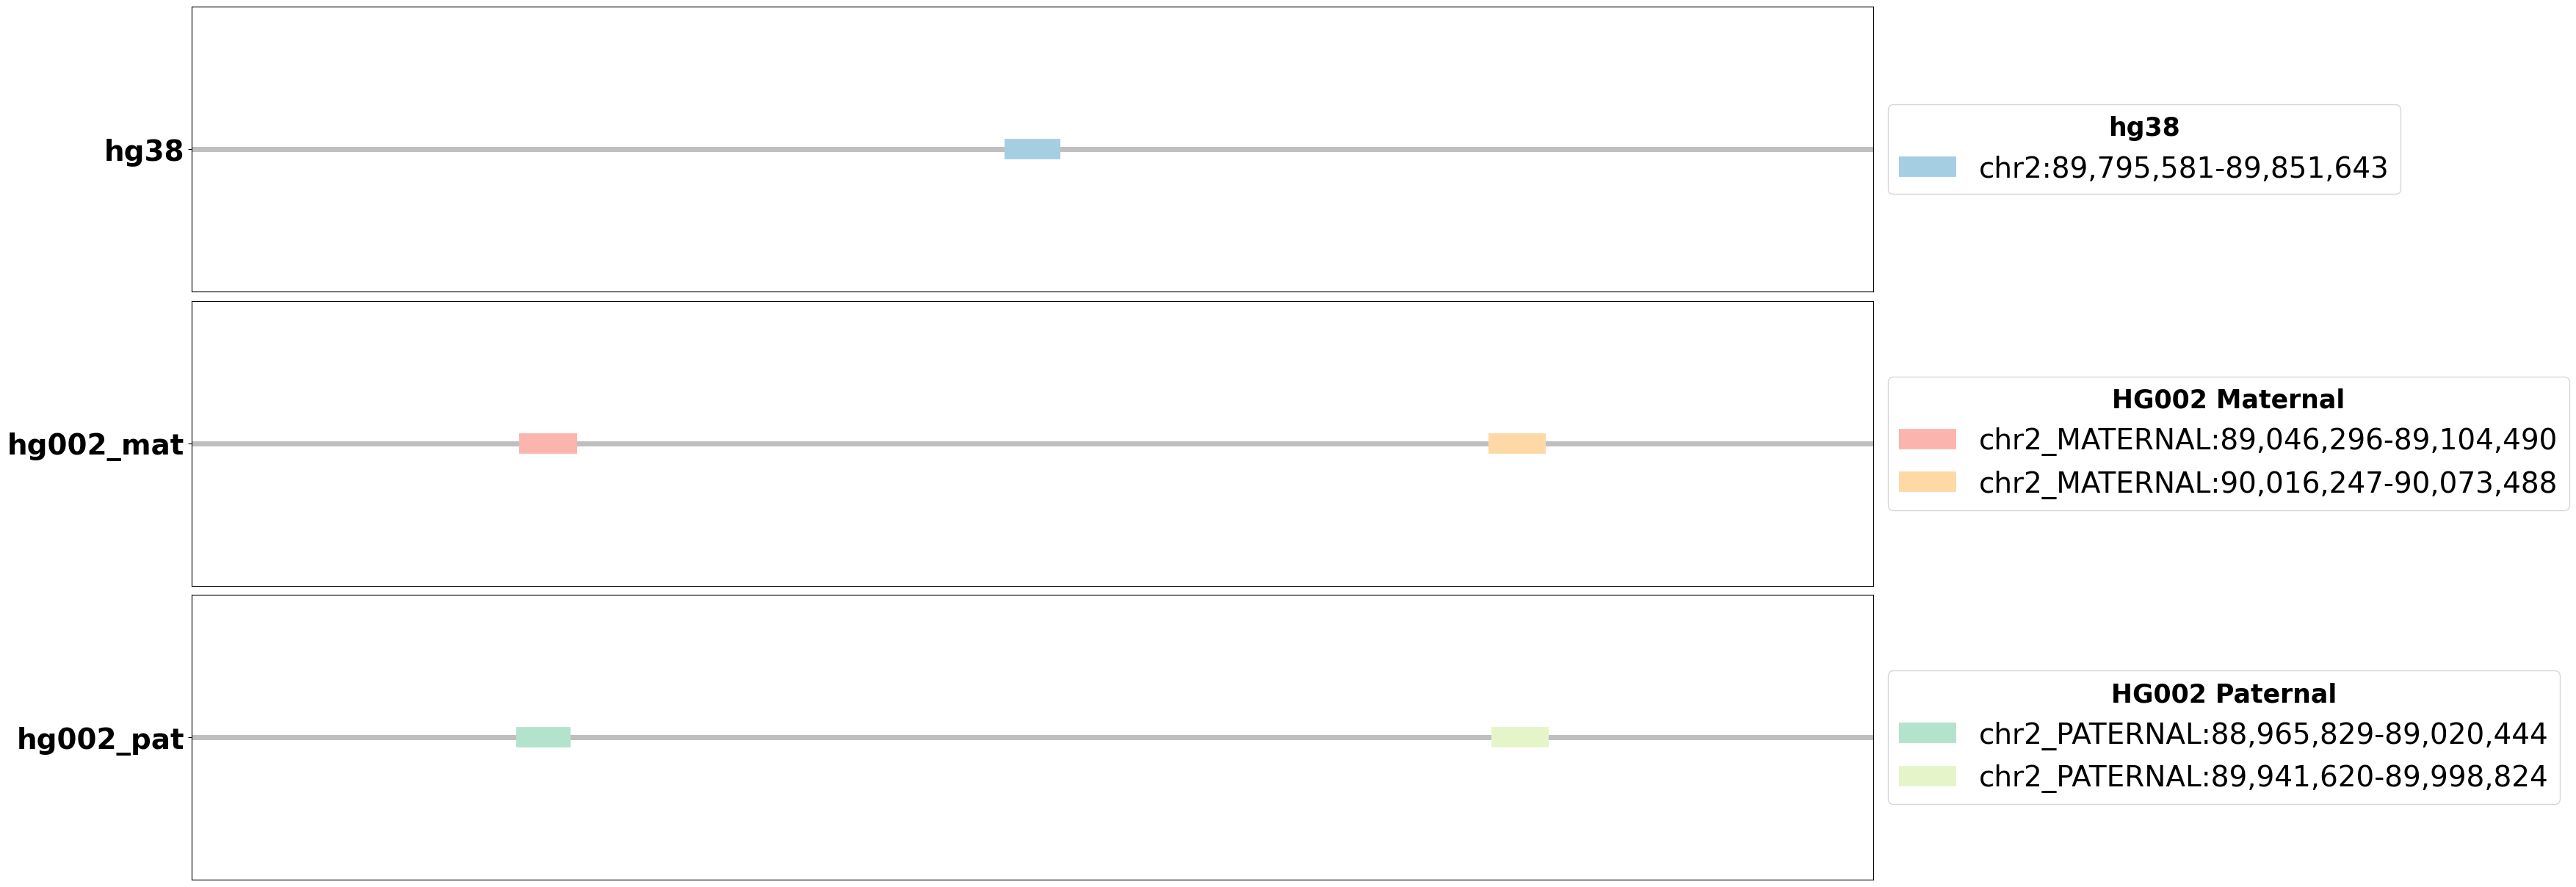

In [14]:
avu.PlotIntervals(['chr2:89795581-89851643'],
 ['chr2_MATERNAL:90016247-90073488',
  'chr2_PATERNAL:89941620-89998824',
  'chr2_PATERNAL:88965829-89020444',
  'chr2_MATERNAL:89046296-89104490']).plot_intervals_comparison(flanking=False, ratio=30)

In [15]:
# How many times did the DEL sequence occur in HG2-T2T?
v.align_interval("chr2:89815283-89817768", ReferenceLocations.hg38, hg38, hg002t2t) 

([['chr2:89815282-89817768', 1]],
 [['chr2_PATERNAL:89961304-89963795', 1],
  ['chr2_MATERNAL:90035956-90038437', 1]])

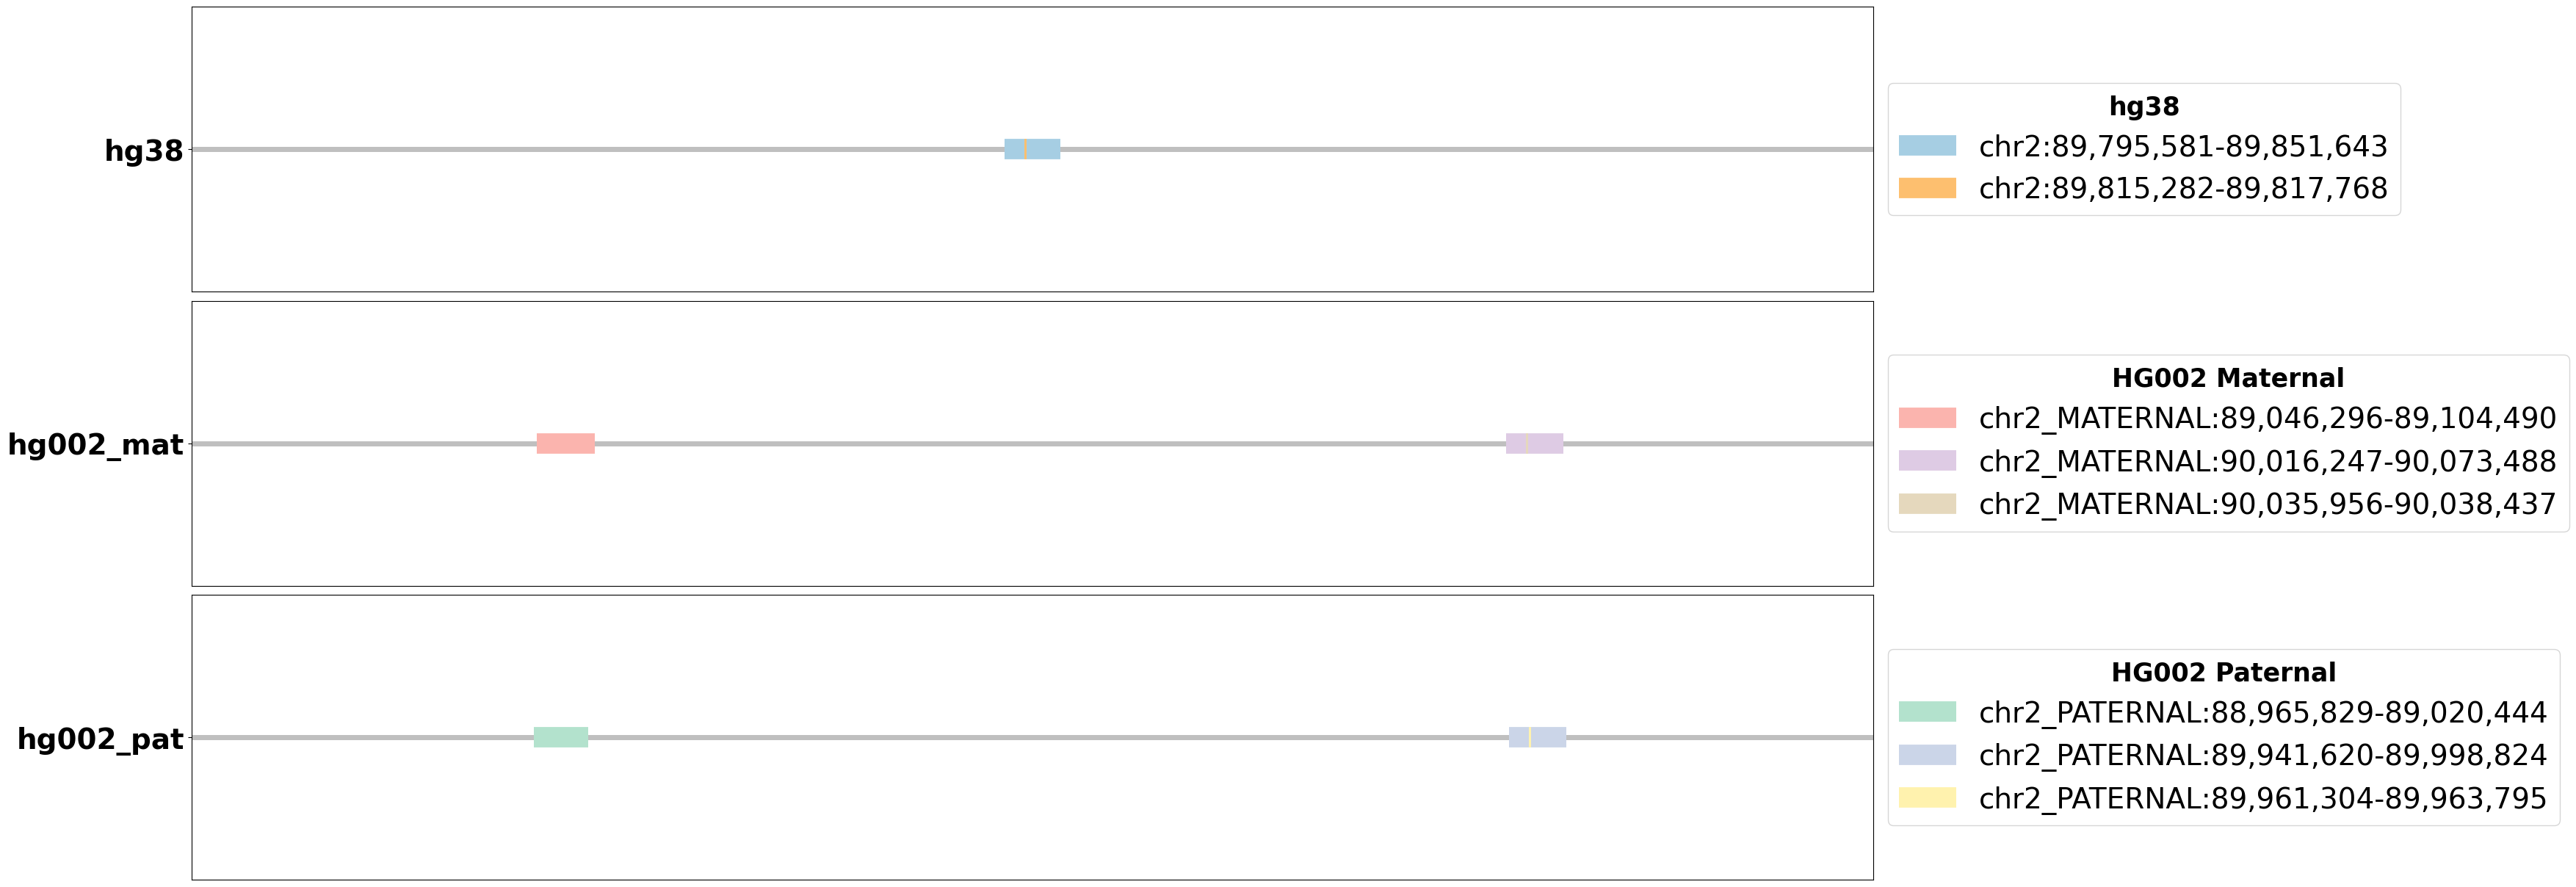

In [16]:
avu.PlotIntervals(['chr2:89795581-89851643','chr2:89815282-89817768'],
 ['chr2_MATERNAL:90016247-90073488',
  'chr2_PATERNAL:89941620-89998824',
  'chr2_PATERNAL:88965829-89020444',
  'chr2_MATERNAL:89046296-89104490',
  'chr2_PATERNAL:89961304-89963795',
  'chr2_MATERNAL:90035956-90038437']).plot_intervals_comparison(flanking=False, ratio=30)

# Overlapping Events Intervals

In [17]:
overlapping_del_dict = ip.find_overlapping_intervals(DEL_pass_intervals)
overlapping_dup_dict = ip.find_overlapping_intervals(DUP_pass_intervals)
print('Number of overlapping DEL events:',len(overlapping_del_dict))    
print('Number of overlapping DUP events:',len(overlapping_dup_dict))    

Number of overlapping DEL events: 63
Number of overlapping DUP events: 13


In [18]:
# Check a DEL within DEL case
v.get_flanking_pairs("chr1:1934990-1935584", ReferenceLocations.hg38, hg38, hg002t2t)

chr1:1934489-1934989 chr1:1935584-1936084 594
chr1_MATERNAL:1371773-1372273 chr1_MATERNAL:1372868-1373370 594


{'ref_flank': [('chr1:1934489-1934989', 'chr1:1935584-1936084', 594)],
 'truth_flank': [('chr1_MATERNAL:1371773-1372273',
   'chr1_MATERNAL:1372868-1373370',
   594)]}

# Test DUP within DUP function

In [19]:
## Build function to evaluate DEL within DUP cases
# TODO: 1. Evaluate if the DUP is a real DUP DONE
# TODO: 2. Check the location of the DEL sequence in HG2-T2T DONE
# TODO: 3. Check if the DEL sequence is within the DUP copies in HG2-T2T DONE
# TODO: 4. Construct right and left flanking regions to evaluate the DEL DONE
# TODO: 5. Check distance between the flanking regions DONE
# TODO: 6. Plot the alignment of the flanking regions DONE
# TODO: 7. Make it into a function DONE

chr2:89795582-89851643 is a real DUP. It has 4 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:4

DEL copies in hg38:1
DEL copies in HG2:2

DEL in DUP copy: chr2_MATERNAL:90035956-90038437 chr2_MATERNAL:90016247-90073488
DEL in DUP copy: chr2_PATERNAL:89961304-89963795 chr2_PATERNAL:89941620-89998824

Left flanking region: chr2:89795582-89815282; HG2 Copies: 4
DEL length: 2486 bp
Right flanking region: chr2:89817768-89851643; HG2 Copies: 4


chr2_PATERNAL:89941620-89961304 chr2_PATERNAL:89963794-89998824 2489
chr2_MATERNAL:90016247-90035956 chr2_MATERNAL:90038436-90073488 2479
* chr2_PATERNAL:89000725-89020444 chr2_PATERNAL:88965829-89000724 0
chr2_MATERNAL:89084781-89104490 chr2_MATERNAL:89046296-89081210 3570


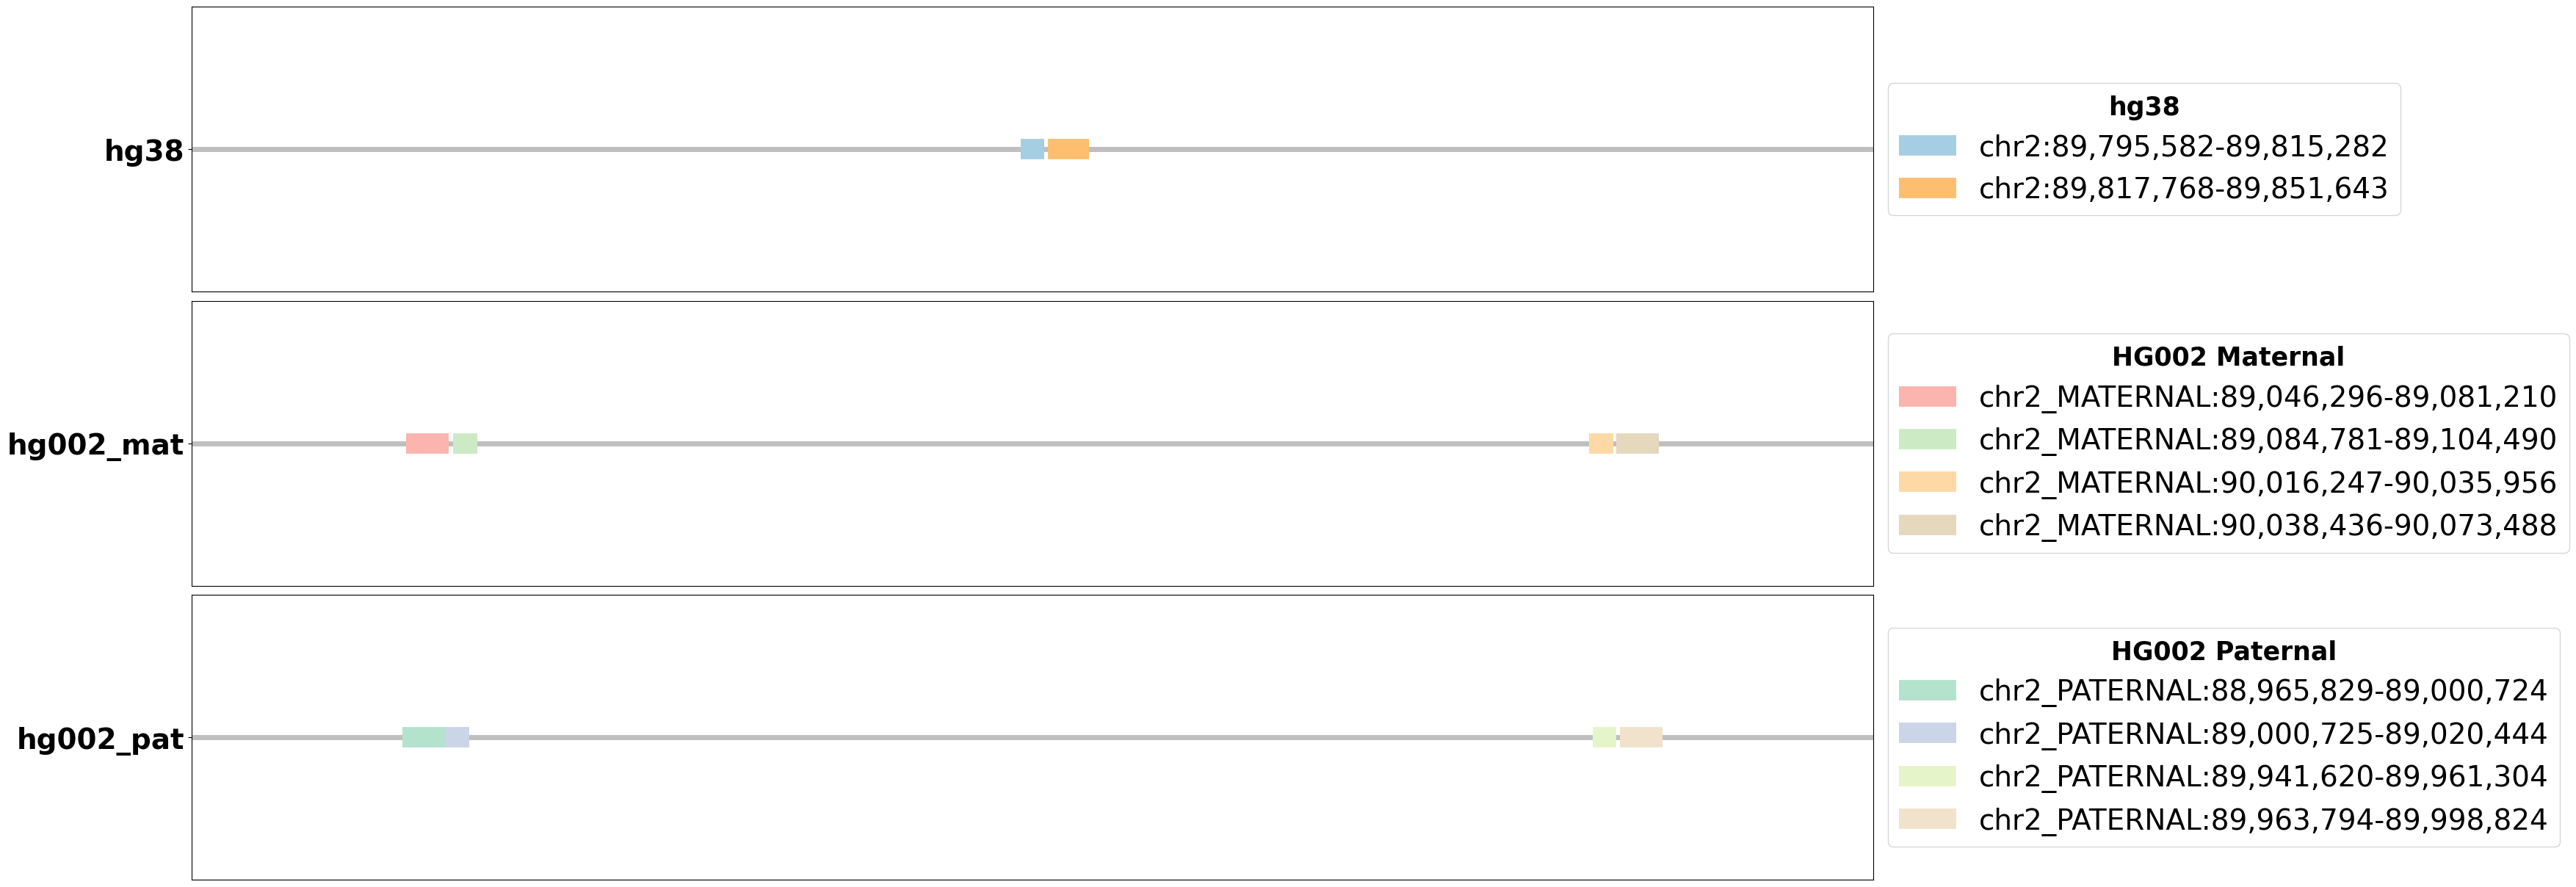

In [131]:
# Test the eval_del_in_dup function
dup_interval = "chr2:89795582-89851643"
del_interval = "chr2:89815283-89817768"

try:
    v.eval_del_in_dup(del_interval,dup_interval, ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=70)
except SystemExit as e:
    print(e)

In [132]:
# Test Error handling of the eval_del_in_dup function
try:
    v.eval_del_in_dup(dup_interval,del_interval, ReferenceLocations.hg38, hg38, hg002t2t)
except SystemExit as e:
    print(e)

DEL interval chr2:89795582-89851643 not within DUP interval chr2:89815283-89817768


In [23]:
# The eval_del_in_dup function is working
# Test the function on the DUP within DEL cases

for index,del_in_dup_pair in enumerate(del_within_dup_list):
    if len(v.align_interval(del_in_dup_pair[1], ReferenceLocations.hg38, hg38, hg002t2t)[1]) <= 2:
        print(f'{index}.DEL within DUP: {del_in_dup_pair[0]}, {del_in_dup_pair[1]}')
        print('Complex DUP requires further investigation')
    else:
        print('--------------------------------------------')
        print(f'{index}.DEL within DUP: {del_in_dup_pair[0]}, {del_in_dup_pair[1]}')
        v.eval_del_in_dup(del_in_dup_pair[0],del_in_dup_pair[1], ReferenceLocations.hg38, hg38, hg002t2t)
        print('--------------------------------------------')

--------------------------------------------
0.DEL within DUP: chr1:13235347-13240700, chr1:13225212-13247040
chr1:13225212-13247040 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:3

DEL copies in hg38:1
DEL copies in HG2:3

DEL in DUP copy: chr1_PATERNAL:12625265-12630588 chr1_PATERNAL:12618932-12640735
DEL in DUP copy: chr1_MATERNAL:12661062-12666390 chr1_MATERNAL:12654730-12676537
DEL in DUP copy: chr1_MATERNAL:12878375-12883746 chr1_MATERNAL:12868220-12890084

Left flanking region: chr1:13225212-13235346; HG2 Copies: 4
DEL length: 5354 bp
Right flanking region: chr1:13240700-13247040; HG2 Copies: 4


chr1_MATERNAL:12666390-12676537 chr1_MATERNAL:12654730-12661063 5326
chr1_PATERNAL:12630588-12640735 chr1_PATERNAL:12618932-12625266 5321
chr1_MATERNAL:12868220-12878375 chr1_MATERNAL:12883745-12890084 5369
* chr1_PATERNAL:12789954-12800106 chr1_PATERNAL:12800107-12806396 0
--------------------------------------------
----------

chr14:19725013-19956413 is a real DUP. It has 4 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:4

DEL copies in hg38:1
DEL copies in HG2:3

DEL in DUP copy: chr14_PATERNAL:19603805-19607273 chr14_PATERNAL:19420937-19652399
DEL in DUP copy: chr14_MATERNAL:20387438-20390906 chr14_MATERNAL:20204466-20435991
DEL in DUP copy: chr14_MATERNAL:21858387-21861855 chr14_MATERNAL:21675534-21906954

Left flanking region: chr14:19725013-19907851; HG2 Copies: 4
DEL length: 3468 bp
Right flanking region: chr14:19911319-19956413; HG2 Copies: 4


chr14_PATERNAL:19420937-19603805 chr14_PATERNAL:19607272-19652399 3466
chr14_MATERNAL:20204466-20387438 chr14_MATERNAL:20390905-20435991 3466
* chr14_PATERNAL:18710102-18892983 chr14_PATERNAL:18892984-18938130 0
chr14_MATERNAL:21675534-21858387 chr14_MATERNAL:21861854-21906954 3466


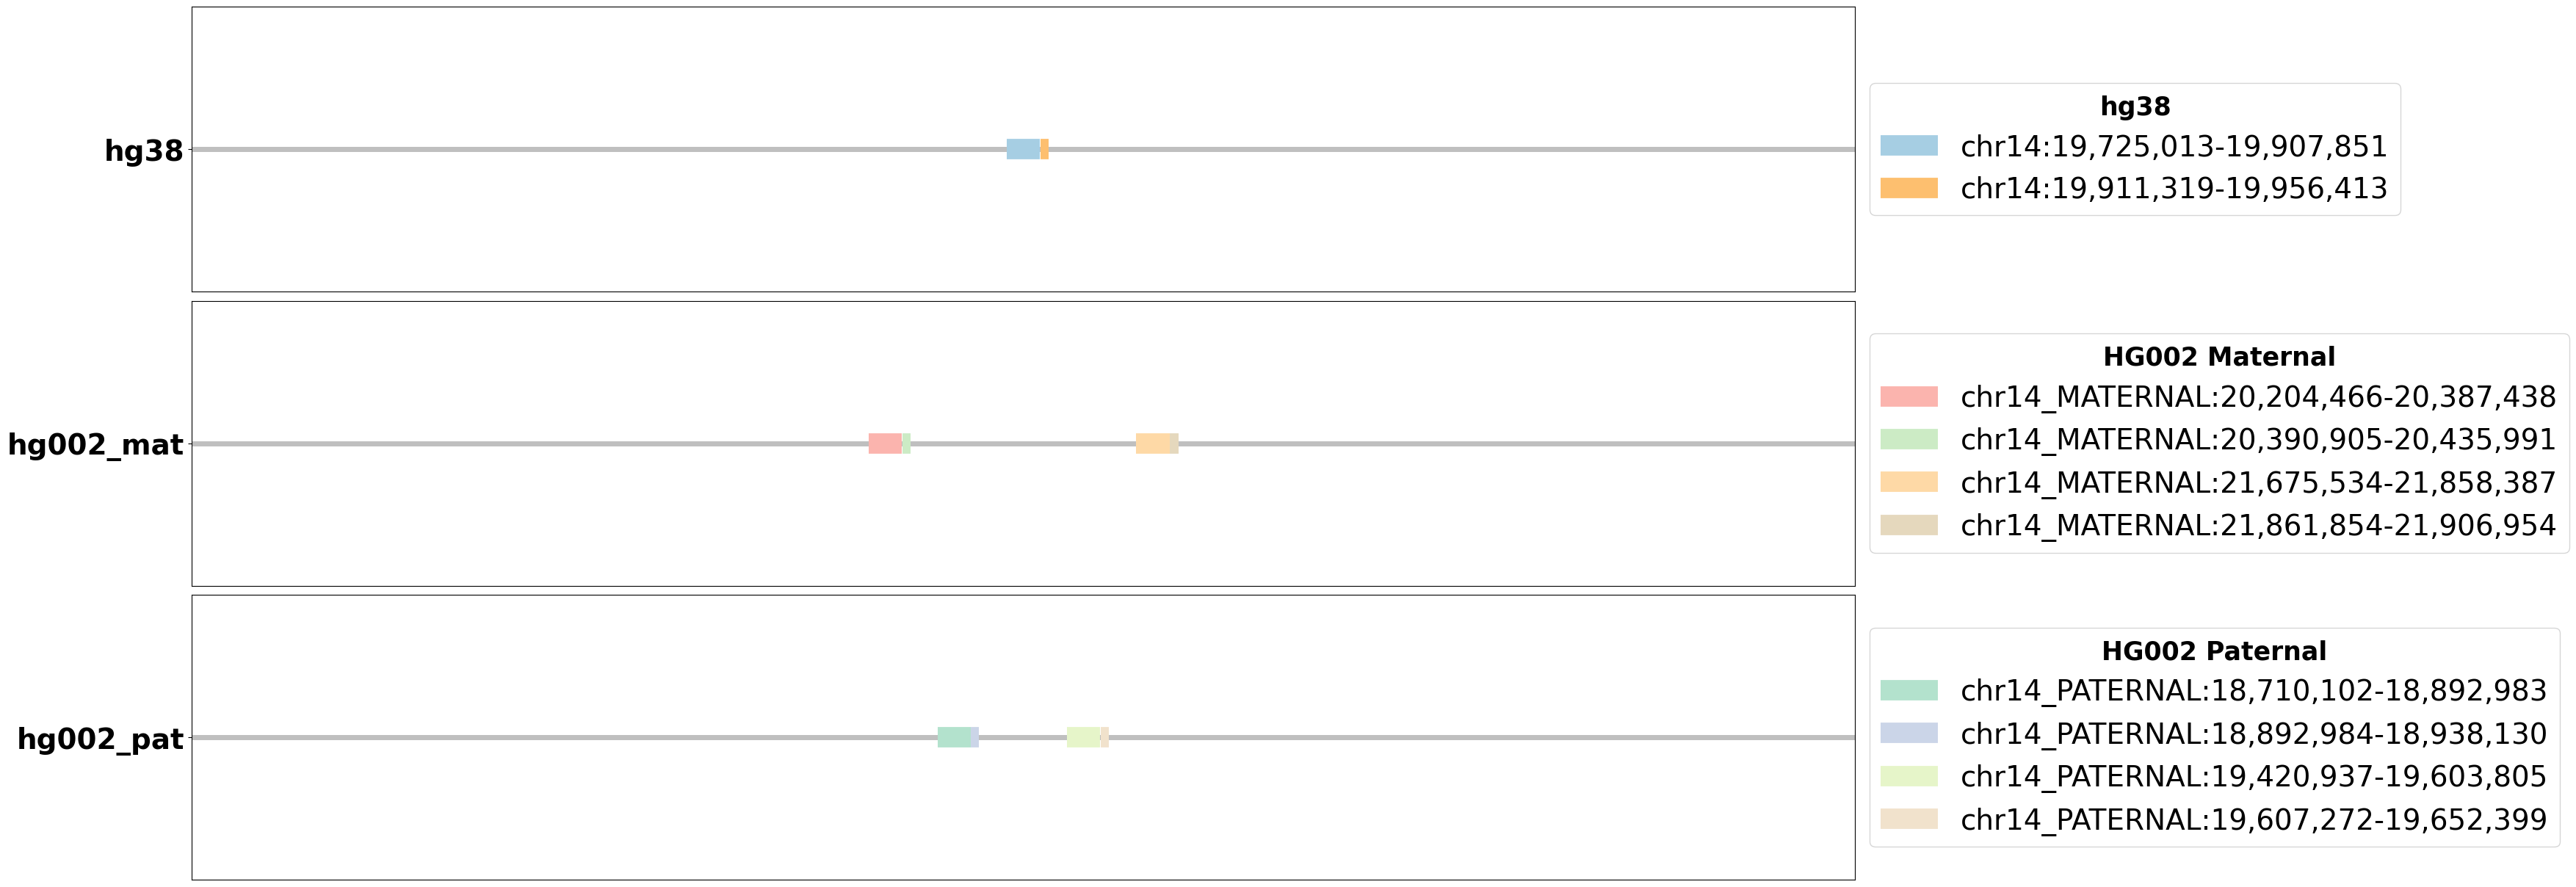

In [48]:
# A good example of DUP within DEL evaluation
v.eval_del_in_dup(del_within_dup_list[3][0],del_within_dup_list[3][1], ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=50,save_plot=True)


chr17:46135409-46292238 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:3

DEL copies in hg38:1
DEL copies in HG2:5

DEL in DUP copy: chr17_MATERNAL:46911623-46912344 chr17_MATERNAL:46809518-46966695

Left flanking region: chr17:46135409-46237500; HG2 Copies: 3
DEL length: 725 bp
Right flanking region: chr17:46238225-46292238; HG2 Copies: 2


chr17_MATERNAL:46809518-46911623 chr17_MATERNAL:46912705-46966695 1081
* chr17_PATERNAL:47165640-47267578 chr17_PATERNAL:47110667-47165639 0
chr17_PATERNAL:47905637-48011428 chr17_PATERNAL:47110667-47165639 739997


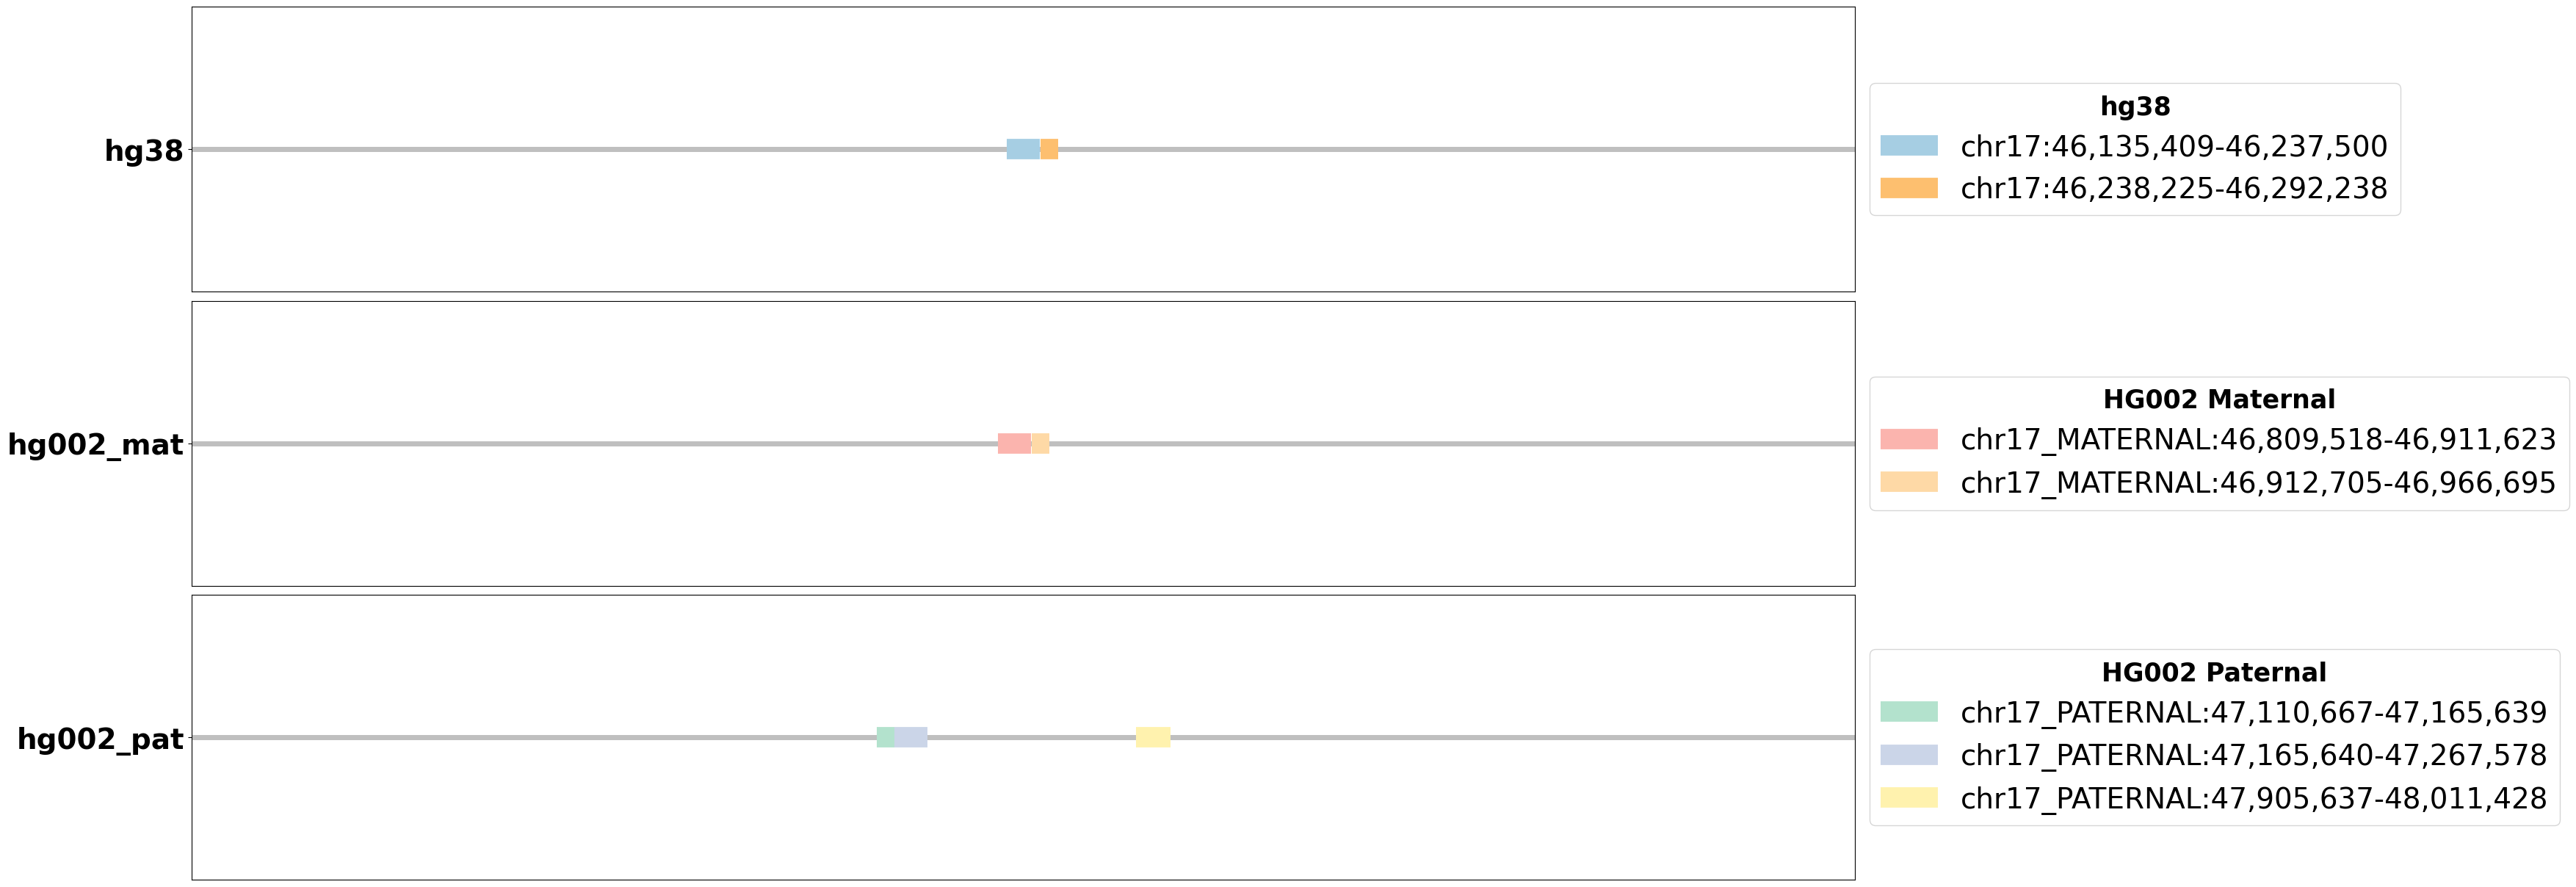

In [25]:
# The right flanking region didn't align to Paternal
# Requires further investigation
v.eval_del_in_dup(del_within_dup_list[9][0],del_within_dup_list[9][1], ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=50,save_plot=True)

In [41]:
# The new DUP interval is 'chr17:46135408-46289364'
# I want to check if the DEL interval is within the new DUP interval

ip.interval_within_interval('chr17:46237501-46238225','chr17:46135408-46289364')

True

chr17:46135408-46289364 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:3

DEL copies in hg38:1
DEL copies in HG2:5

DEL in DUP copy: chr17_MATERNAL:46911623-46912344 chr17_MATERNAL:46809517-46963811

Left flanking region: chr17:46135408-46237500; HG2 Copies: 3
DEL length: 725 bp
Right flanking region: chr17:46238225-46289364; HG2 Copies: 2


chr17_MATERNAL:46809517-46911623 chr17_MATERNAL:46912705-46963811 1081
* chr17_PATERNAL:47165640-47267579 chr17_PATERNAL:47113550-47165639 0
chr17_PATERNAL:47905637-48011428 chr17_PATERNAL:47113550-47165639 739997


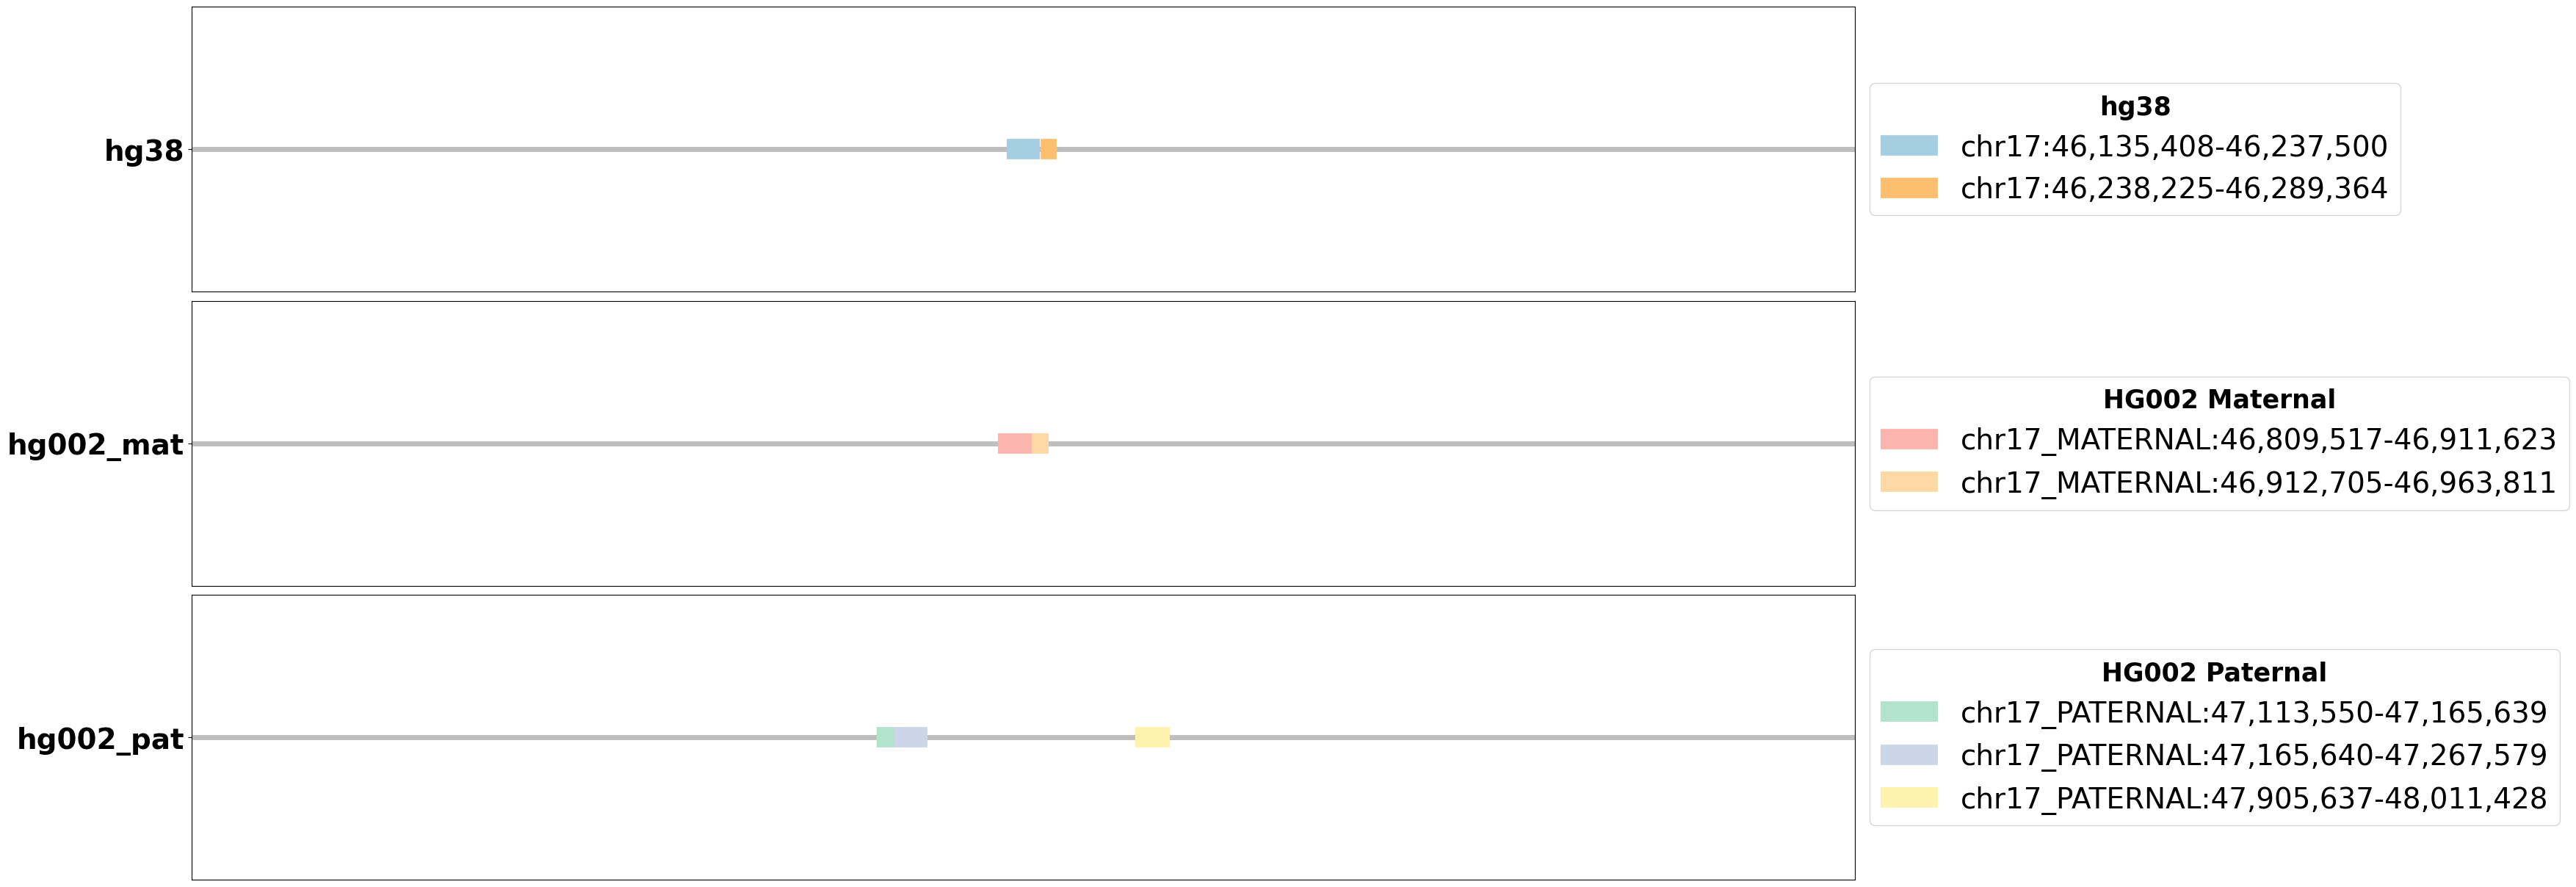

In [42]:
# So it is still in. Let's check the alignment of the flanking regions
v.eval_del_in_dup('chr17:46237501-46238225','chr17:46135408-46289364', ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=50,save_plot=True)

chr17:46135409-46292238 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:3

DEL copies in hg38:1
DEL copies in HG2:2

DEL in DUP copy: chr17_MATERNAL:46952204-46956665 chr17_MATERNAL:46809518-46966695
DEL in DUP copy: chr17_PATERNAL:47120692-47125139 chr17_PATERNAL:47110667-47267578

Left flanking region: chr17:46135409-46277762; HG2 Copies: 3
DEL length: 4458 bp
Right flanking region: chr17:46282220-46292238; HG2 Copies: 4


chr17_MATERNAL:46809518-46952204 chr17_MATERNAL:46956664-46966695 4459
chr17_PATERNAL:47125141-47267578 chr17_PATERNAL:47110667-47120693 4447
chr17_PATERNAL:47866533-48011428 chr17_PATERNAL:47836459-47846499 20033


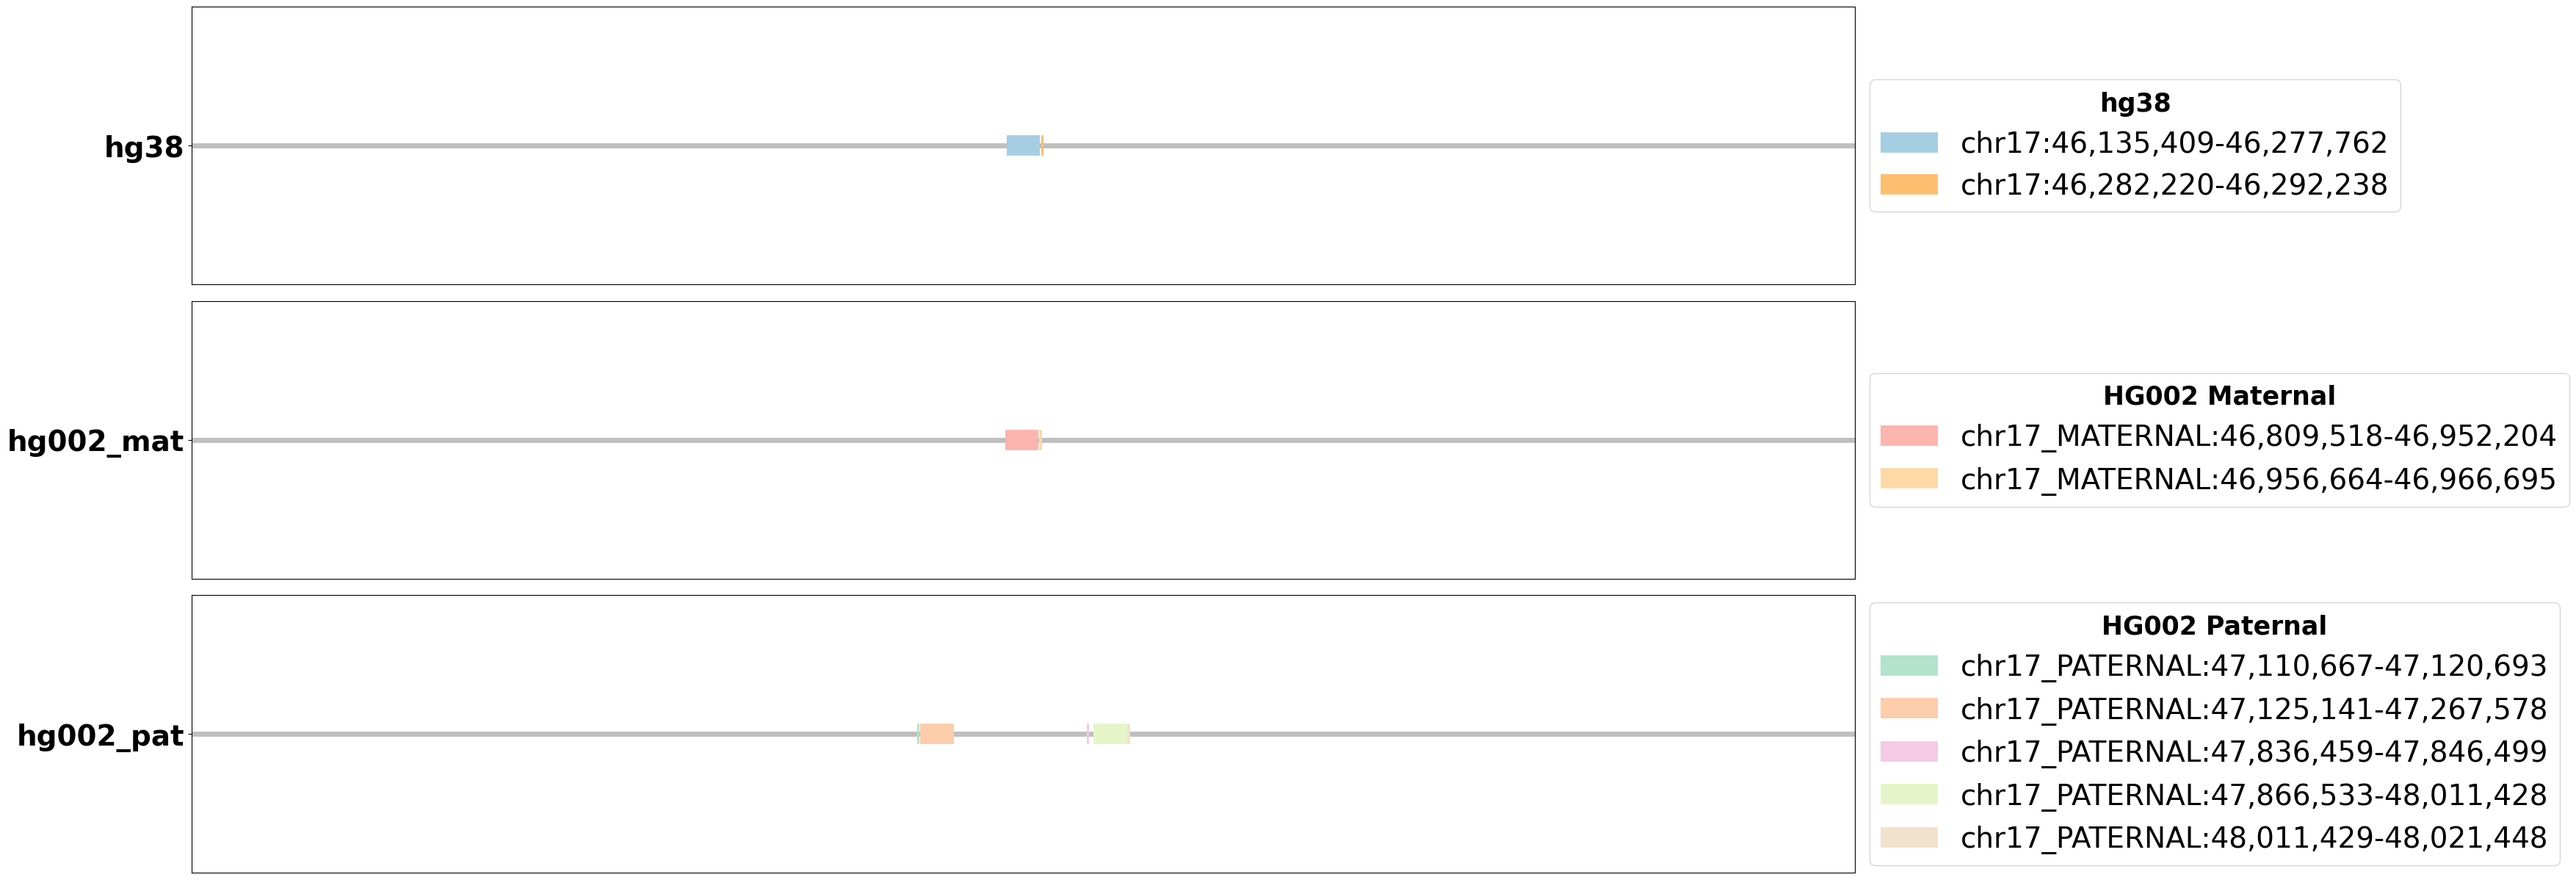

In [45]:
# Unresolved DUP within DEL case
v.eval_del_in_dup(del_within_dup_list[12][0],del_within_dup_list[12][1], ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=50,save_plot=True)

In [98]:
del_within_dup_list[13]

['chr17:46277763-46282220', 'chr17:46135409-46282220']

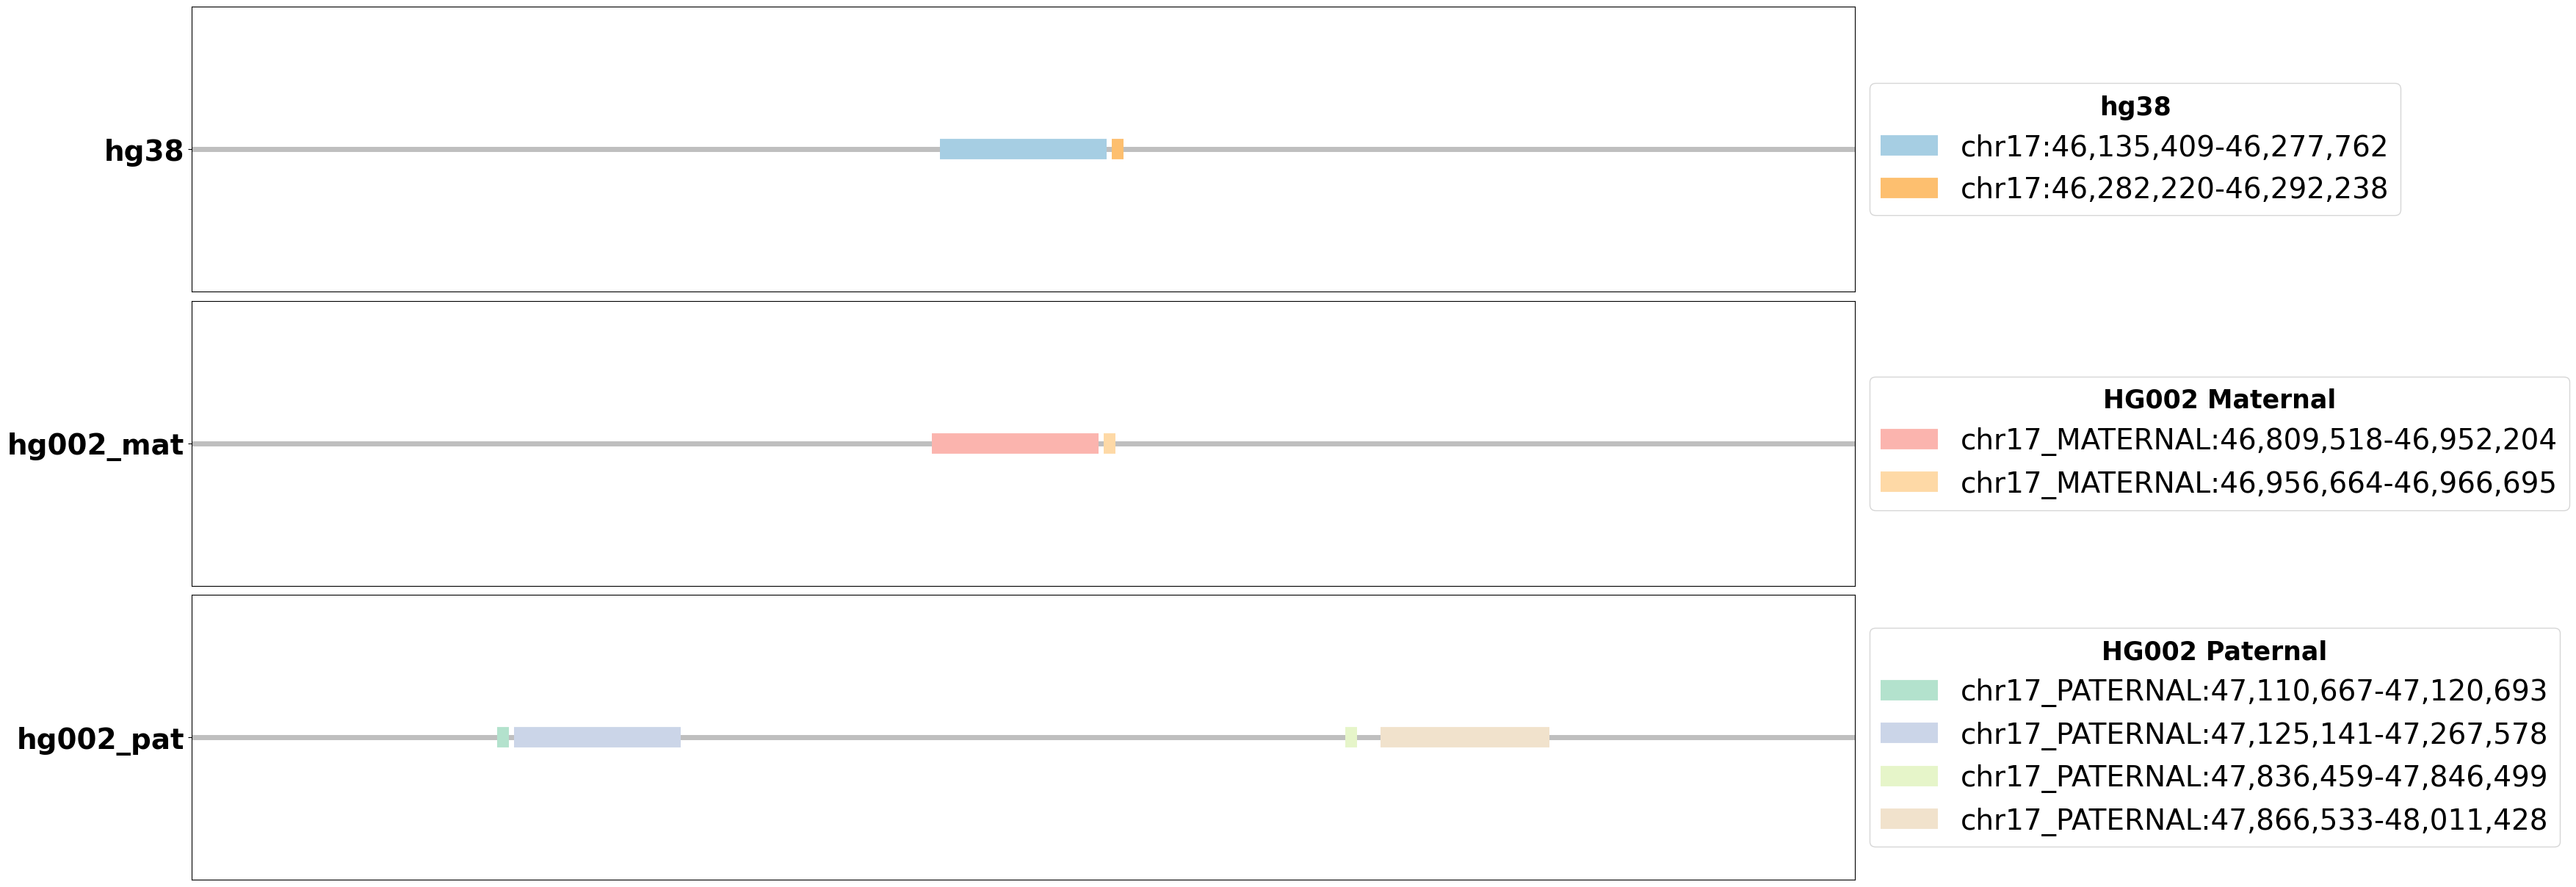

In [90]:
# ['chr17:46277763-46282220', 'chr17:46135409-46282220']
# Number 13 in del_within_dup_list
avu.PlotIntervals(['chr17:46135409-46277762', 'chr17:46282220-46292238'],['chr17_MATERNAL:46809518-46952204','chr17_MATERNAL:46956664-46966695','chr17_PATERNAL:47125141-47267578','chr17_PATERNAL:47110667-47120693',
'chr17_PATERNAL:47866533-48011428','chr17_PATERNAL:47836459-47846499']).plot_intervals_comparison(flanking=False,ratio=10, save=True)


In [105]:
# The ending of DUP interval is the same as the ending of the DEL interval
# This situation will be handled by the eval_del_in_dup function by reporting error
v.eval_del_in_dup(del_within_dup_list[13][0],del_within_dup_list[13][1], ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=50,save_plot=False)

SystemExit: DEL interval chr17:46277763-46282220 not within DUP interval chr17:46135409-46282220

/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Eval All DUPs

In [135]:
# Eval all DUPs
# Check their copy number in HG2-T2T and hg38
dup_aln_dict = {}
for interval in DUP_pass_intervals:
    dup_aln_dict[interval] = v.eval_dup(interval, ReferenceLocations.hg38, hg38, hg002t2t)

chr1:13225212-13247040 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38
chr1:16605768-16645359 is a real DUP. It has 5 copy(ies) in HG2 and 1 copy(ies) in hg38

chr1:16715826-16727637 is a real DUP. It has 5 copy(ies) in HG2 and 1 copy(ies) in hg38
chr1:16879014-16949283 is a real DUP. It has 4 copy(ies) in HG2 and 1 copy(ies) in hg38
chr1:143207550-143272360 is a real DUP. It has 10 copy(ies) in HG2 and 1 copy(ies) in hg38
chr1:248407553-248446847 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

chr2:16225124-16226720 is not a DUP. It has 2 copy(ies) in HG2 and 1 copy(ies) in hg38

chr2:74330292-74331319 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38
chr2:89673674-89790690 is a real DUP. It has 5 copy(ies) in HG2 and 2 copy(ies) in hg38
chr2:89795582-89851643 is a real DUP. It has 4 copy(ies) in HG2 and 1 copy(ies) in hg38
chr2:91408761-91423450 is not a DUP. It has 2 copy(ies) in HG2 and 1 copy(ies) in hg38

chr2:122526667-122536995 

In [136]:
dup_df = pd.DataFrame()
dup_df['dup_interval'] = dup_aln_dict.keys()
dup_df['dup_hg38_aln'] = [i[0] for i in dup_aln_dict.values()]
dup_df['dup_hg2_aln'] = [i[1] for i in dup_aln_dict.values()]
dup_df['dup_hg2_aln_ratio'] = dup_aln_dict.values()
dup_df 

,dup_interval,dup_hg38_aln,dup_hg2_aln,dup_hg2_aln_ratio
0,chr1:13225212-13247040,1,3,"(1, 3)"
1,chr1:16605768-16645359,1,5,"(1, 5)"
2,chr1:16715826-16727637,1,5,"(1, 5)"
3,chr1:16879014-16949283,1,4,"(1, 4)"
4,chr1:143207550-143272360,1,10,"(1, 10)"
...,...,...,...,...
109,chrY:10670735-10691642,3,3,"(3, 3)"
110,chrY:10670736-10674040,1,1,"(1, 1)"
111,chrY:11333248-11360005,1,1,"(1, 1)"
112,chrY:56822082-56838588,1,1,"(1, 1)"


In [143]:
inconsistant_copy_dup_intervals = [row['dup_interval'] for index, row in dup_df.iterrows() if row['dup_hg2_aln'] <= row['dup_hg38_aln']*2]

print("Number of inconsistent alignment for DUPs:",len(inconsistant_copy_dup_intervals))

Number of inconsistent alignment for DUPs: 42


In [210]:
tp_dups = [row['dup_interval'] for index, row in dup_df.iterrows() if row['dup_hg2_aln'] > row['dup_hg38_aln']*2]
print("Number of consistent alignment for DUPs (TP DUPs):", len(tp_dups))

Number of consistent alignment for DUPs (TP DUPs): 72


In [146]:
# Save the inconsistent copy DUPs to a csv file for further investigation documentation
inconsistant_copy_dup_df = dup_df[dup_df['dup_interval'].isin(inconsistant_copy_dup_intervals)]
inconsistant_copy_dup_df.head()

inconsistant_copy_dup_df.to_csv('/Users/gaoyueya/Documents/Projects/TAG-Ticket1789/T2T-ACE_Inconsistant_Copy_DUPs.csv',index=False)

,dup_interval,dup_hg38_aln,dup_hg2_aln,dup_hg2_aln_ratio
6,chr2:16225124-16226720,1,2,"(1, 2)"
10,chr2:91408761-91423450,1,2,"(1, 2)"
12,chr3:75683120-75707351,1,2,"(1, 2)"
13,chr3:90558126-90571944,2,2,"(2, 2)"
14,chr3:146672617-146677378,1,2,"(1, 2)"


In [147]:
# For the inconsistant copy DUPs, I want to check their alignment in hg38 and HG2-T2T
inconsistant_copy_dup_df['dup_hg2_aln_ratio'].value_counts()

dup_hg2_aln_ratio
(1, 2)    31
(1, 1)     7
(2, 2)     1
(2, 4)     1
(3, 5)     1
(3, 3)     1
Name: count, dtype: int64

In [151]:
copy_neutral_intervals = inconsistant_copy_dup_df[(inconsistant_copy_dup_df['dup_hg38_aln']==1)&(inconsistant_copy_dup_df['dup_hg2_aln']==2)]["dup_interval"].tolist()
print('Number of DUPs that has alignments that is hg38=1, hg2=2:', len(copy_neutral_intervals))

Number of DUPs that has alignments that is hg38=1, hg2=2: 31


In [366]:
# This function is to create sliding window alignment for DUPs
def bin_alignment(interval, window_size=1000):
    sliding_window_interval_list = []
    sliding_window_hg38_hit_list = []
    sliding_window_hg2_mat_hit_list = []
    sliding_window_hg2_pat_hit_list = []
    sliding_window_hg2_hit_list = []
    chr,pos,end = ip.parse_interval(interval)

    
    # Make sure the last sliding window is not out of the original interval
    while pos <= end-window_size:
        sliding_interval = ip.create_interval(chr, pos, pos+window_size)
        pos += window_size
        #print(sliding_interval,len(v.align_interval(sliding_interval, ReferenceLocations.hg38, hg38, hg002t2t)[0]),len(v.align_interval(sliding_interval, ReferenceLocations.hg38, hg38, hg002t2t)[1]))
        sliding_window_interval_list.append(sliding_interval)
        # Number of copies in hg38
        sliding_window_hg38_hit_list.append(len(v.align_interval(sliding_interval, ReferenceLocations.hg38, hg38, hg002t2t)[0]))
        # Number of copies in HG2-T2T MAT
        sliding_window_hg2_mat_hit_list.append(len([i for i,j in v.align_interval(sliding_interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'MAT' in i]))
        # Number of copies in HG2-T2T PAT
        sliding_window_hg2_pat_hit_list.append(len([i for i,j in v.align_interval(sliding_interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'PAT' in i]))
        # Number of copies in HG2-T2T
        sliding_window_hg2_hit_list.append(len(v.align_interval(sliding_interval, ReferenceLocations.hg38, hg38, hg002t2t)[1]))
    
    return sliding_window_interval_list,sliding_window_hg38_hit_list,sliding_window_hg2_mat_hit_list,sliding_window_hg2_pat_hit_list,sliding_window_hg2_hit_list

In [367]:
bin_alignment('chr17:21815040-21825911')

(['chr17:21815040-21816040',
  'chr17:21816040-21817040',
  'chr17:21817040-21818040',
  'chr17:21818040-21819040',
  'chr17:21819040-21820040',
  'chr17:21820040-21821040',
  'chr17:21821040-21822040',
  'chr17:21822040-21823040',
  'chr17:21823040-21824040',
  'chr17:21824040-21825040'],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [376]:
for i in [1,2,3]:
    print(len(bin_alignment(tp_dups[19])[i]))

153
153
153


In [382]:
#TODO: Plot the copy number of the DUPs in MAT and PAT in HG2-T2T DONE
# Function to plot single plot for single interval bin_alignment
def plot_single_bin_alignment(interval):
    # Get the number of copies of the whole interval
    whole_interval_hg38_hit = len(v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[0])
    whole_interval_hg2_mat_hit = len([i for i,j in v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'MAT' in i])
    whole_interval_hg2_pat_hit = len([i for i,j in v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'PAT' in i])
    whole_interval_hg2_hit = len(v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1])
    
    # Use SVLEN to determine the window size
    svlen = ip.interval_size(interval)
    if svlen< 10000:
        window_size = int(np.round(svlen/15))
    else:
        window_size = 1000
    sliding_window_interval_list,sliding_window_hg38_hit_list,sliding_window_hg2_mat_hit_list,sliding_window_hg2_pat_hit_list,sliding_window_hg2_hit_list = bin_alignment(interval,window_size)
    # print(len(sliding_window_interval_list),len(sliding_window_hg38_hit_list),len(sliding_window_hg2_mat_hit_list),len(sliding_window_hg2_pat_hit_list),len(sliding_window_hg2_hit_list))
            
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)


    for i in sliding_window_interval_list:
        if sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)] < sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)] or sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)] < sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)]: 
            axs[0].plot(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], '*', color='blue')
            axs[1].plot(i, sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
            axs[2].plot(i, sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
            axs[3].plot(i, sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
        else:
            axs[0].plot(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
            axs[1].plot(i, sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
            axs[2].plot(i, sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
            axs[3].plot(i, sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')

    axs[0].set_title(f'hg38 ({whole_interval_hg38_hit})')
    axs[0].set_ylim(0, 10)
    axs[0].set_xticks('')

    axs[1].set_title(f'HG2-MAT ({whole_interval_hg2_mat_hit})')
    axs[1].set_ylim(0, 10)
    axs[1].set_xticks('')

    axs[2].set_title(f'HG2-PAT ({whole_interval_hg2_pat_hit})')
    axs[2].set_ylim(0, 10)
    axs[2].set_xticks('')

    axs[3].set_title(f'HG2-T2T ({whole_interval_hg2_hit})')
    axs[3].set_ylim(0, 10)
    axs[3].set_xticks('')

    fig.suptitle(f'{interval} ({ip.interval_size(interval)}bp)')
    plt.tight_layout()


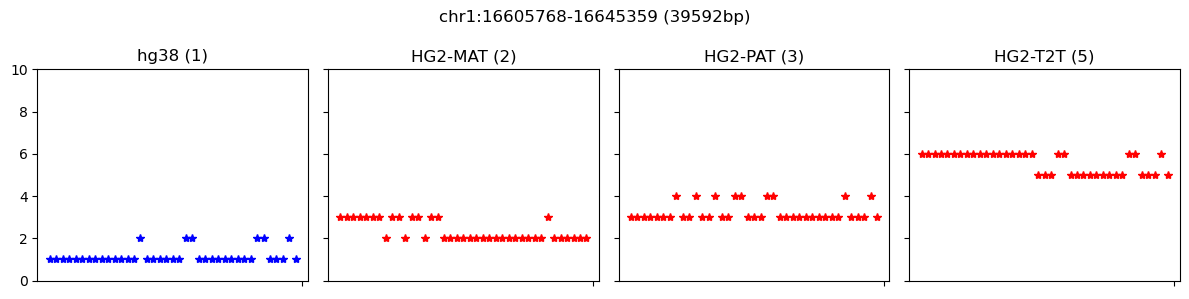

In [384]:
plot_single_bin_alignment(tp_dups[1])

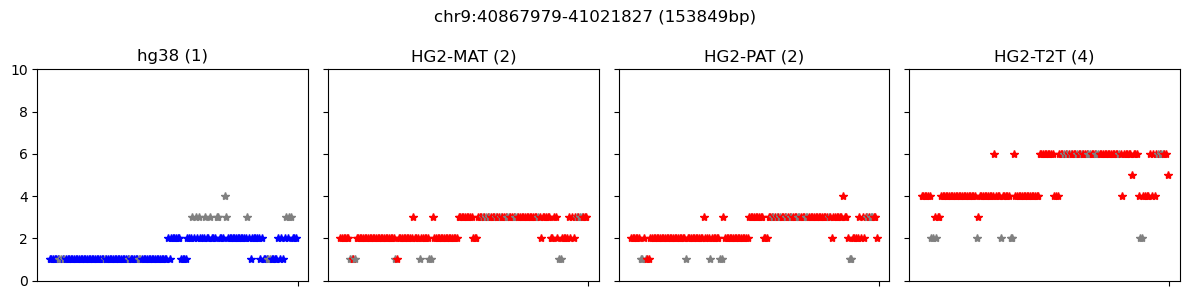

In [383]:
plot_single_bin_alignment(tp_dups[19])

In [393]:
# Process centromere intervals from USCS
# And annotate the DUPs that overlap with centromere
uscs_centromere_df = pd.read_csv("/Users/gaoyueya/Documents/GitHub/T2T-ACE/resources/centromeres.txt", sep='\t',header=None,names=['bin','chr','pos','end','name'])
#uscs_centromere_df[uscs_centromere_df['chr']=='chr1']
#len(uscs_centromere_df)
uscs_centromere_list = [ip.create_interval(row['chr'],row['pos'],row['end']) for index, row in uscs_centromere_df.iterrows()]
print('Number of Centromere Intervals:',len(uscs_centromere_list))

Number of Centromere Intervals: 109


In [400]:
[i for i in uscs_centromere_list if 'chr19' in i]

['chr19:24498980-24552652',
 'chr19:24552752-24891256',
 'chr19:24908689-27190874']

In [394]:
# Check the interval_size of each centromere interval
[ip.interval_size(i) for i in uscs_centromere_list]

[198077,
 278513,
 2282186,
 63598,
 83496,
 249219,
 1561441,
 48181,
 47702,
 11970,
 3251983,
 82576,
 47205,
 2349958,
 22538,
 88023,
 54134,
 63536,
 20671,
 6671,
 3246,
 22562,
 1134212,
 341,
 341,
 1199,
 632587,
 22538,
 88023,
 54134,
 63536,
 20671,
 6671,
 3246,
 22562,
 1134212,
 341,
 341,
 1199,
 632587,
 415279,
 855958,
 1370147,
 23303,
 1928004,
 381240,
 3371616,
 49432,
 319479,
 4763585,
 93043,
 39637,
 76959,
 21410,
 53673,
 338505,
 2282186,
 1902413,
 150724,
 1886395,
 47957,
 80767,
 78876,
 120945,
 22538,
 88023,
 54134,
 63536,
 20671,
 6671,
 3246,
 22562,
 1134212,
 341,
 341,
 1199,
 632587,
 22538,
 88023,
 54134,
 63536,
 20671,
 6671,
 3246,
 22562,
 1134212,
 341,
 341,
 1199,
 632587,
 461129,
 13937,
 2102156,
 2031891,
 83163,
 227564,
 264464,
 46346,
 142631,
 2282186,
 53673,
 338505,
 1276047,
 2658582,
 150233,
 1843522,
 2128924,
 3806964,
 227096]

In [399]:
#"chr19:27346020-27398099"
# This interval seems to be a centromere interval
# However, it is not in the uscs_centromere_list
ip.find_overlapping_intervals(["chr19:27346020-27398099"]+uscs_centromere_list)

defaultdict(list, {})

In [398]:
# Check the copy_neutral_intervals that overlap with centromere
for i in copy_neutral_intervals:
    if ip.find_overlapping_intervals([i]+uscs_centromere_list):
        print(i)

In [ ]:
#TODO: Plot the copy number of the DUPs in MAT and PAT in HG2-T2T DONE
# Function to plot single plot for single interval bin_alignment
def plot_single_bin_alignment(interval):
    # Get the number of copies of the whole interval
    whole_interval_hg38_hit = len(v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[0])
    whole_interval_hg2_mat_hit = len([i for i,j in v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'MAT' in i])
    whole_interval_hg2_pat_hit = len([i for i,j in v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'PAT' in i])
    whole_interval_hg2_hit = len(v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1])
    
    # Use SVLEN to determine the window size
    svlen = ip.interval_size(interval)
    if svlen< 10000:
        window_size = int(np.round(svlen/15))
    else:
        window_size = 1000
    sliding_window_interval_list,sliding_window_hg38_hit_list,sliding_window_hg2_mat_hit_list,sliding_window_hg2_pat_hit_list,sliding_window_hg2_hit_list = bin_alignment(interval,window_size)
    # print(len(sliding_window_interval_list),len(sliding_window_hg38_hit_list),len(sliding_window_hg2_mat_hit_list),len(sliding_window_hg2_pat_hit_list),len(sliding_window_hg2_hit_list))
            
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)


    for i in sliding_window_interval_list:
        if sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)] < sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)] or sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)] < sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)]: 
            axs[0].plot(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], '*', color='blue')
            axs[1].plot(i, sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
            axs[2].plot(i, sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
            axs[3].plot(i, sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
        else:
            axs[0].plot(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
            axs[1].plot(i, sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
            axs[2].plot(i, sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
            axs[3].plot(i, sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')

    axs[0].set_title(f'hg38 ({whole_interval_hg38_hit})')
    axs[0].set_ylim(0, 10)
    axs[0].set_xticks('')

    axs[1].set_title(f'HG2-MAT ({whole_interval_hg2_mat_hit})')
    axs[1].set_ylim(0, 10)
    axs[1].set_xticks('')

    axs[2].set_title(f'HG2-PAT ({whole_interval_hg2_pat_hit})')
    axs[2].set_ylim(0, 10)
    axs[2].set_xticks('')

    axs[3].set_title(f'HG2-T2T ({whole_interval_hg2_hit})')
    axs[3].set_ylim(0, 10)
    axs[3].set_xticks('')

    fig.suptitle(f'{interval} ({ip.interval_size(interval)}bp)')
    plt.tight_layout()


In [401]:
from matplotlib.backends.backend_pdf import PdfPages

# Create a function to plot bin_alignment for a list of intervals and save the plots to a pdf file
def plot_multiple_bin_alignment(interval_list, pdf_name):
    with PdfPages(pdf_name) as pdf:
        for interval in interval_list:
            # Get the number of copies of the whole interval
            whole_interval_hg38_hit = len(v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[0])
            whole_interval_hg2_mat_hit = len([i for i,j in v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'MAT' in i])
            whole_interval_hg2_pat_hit = len([i for i,j in v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1] if 'PAT' in i])
            whole_interval_hg2_hit = len(v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1])
            
            # Use SVLEN to determine the window size
            svlen = ip.interval_size(interval)
            if svlen< 10000:
                window_size = int(np.round(svlen/15))
            else:
                window_size = 1000
            sliding_window_interval_list,sliding_window_hg38_hit_list,sliding_window_hg2_mat_hit_list,sliding_window_hg2_pat_hit_list,sliding_window_hg2_hit_list = bin_alignment(interval,window_size)
            # print(len(sliding_window_interval_list),len(sliding_window_hg38_hit_list),len(sliding_window_hg2_mat_hit_list),len(sliding_window_hg2_pat_hit_list),len(sliding_window_hg2_hit_list))
                    
            fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
        
        
            for i in sliding_window_interval_list:
                if sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)] < sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)] or sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)] < sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)]: 
                    axs[0].plot(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], '*', color='blue')
                    axs[1].plot(i, sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
                    axs[2].plot(i, sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
                    axs[3].plot(i, sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)], '*', color='red')
                else:
                    axs[0].plot(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
                    axs[1].plot(i, sliding_window_hg2_mat_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
                    axs[2].plot(i, sliding_window_hg2_pat_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
                    axs[3].plot(i, sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)], '*', color='grey')
        
            axs[0].set_title(f'hg38 ({whole_interval_hg38_hit})')
            axs[0].set_ylim(0, 10)
            axs[0].set_xticks('')
        
            axs[1].set_title(f'HG2-MAT ({whole_interval_hg2_mat_hit})')
            axs[1].set_ylim(0, 10)
            axs[1].set_xticks('')
        
            axs[2].set_title(f'HG2-PAT ({whole_interval_hg2_pat_hit})')
            axs[2].set_ylim(0, 10)
            axs[2].set_xticks('')
        
            axs[3].set_title(f'HG2-T2T ({whole_interval_hg2_hit})')
            axs[3].set_ylim(0, 10)
            axs[3].set_xticks('')
        
            fig.suptitle(f'{interval} ({ip.interval_size(interval)}bp)')
            plt.tight_layout()

            # Save the current figure to the PDF
            pdf.savefig()
            plt.close()

In [402]:
# Check a TP DUP bin performance
plot_multiple_bin_alignment(tp_dups, 'TP_DUP_bin_alignment.pdf')

In [403]:
# Check distribution of the 31 copy_neutral_intervals
plot_multiple_bin_alignment(copy_neutral_intervals, 'copy_neutral_DUP_bin_alignment.pdf')
    

In [254]:
from Bio import pairwise2

In [313]:
# Potential DUP that over-estimated its interval size
'chr17:45572503-45585288'

['chr1:13225212-13247040',
 'chr1:16605768-16645359',
 'chr1:16715826-16727637',
 'chr1:16879014-16949283',
 'chr1:143207550-143272360',
 'chr1:248407553-248446847',
 'chr2:74330292-74331319',
 'chr2:89673674-89790690',
 'chr2:89795582-89851643',
 'chr2:122526667-122536995',
 'chr3:195690502-195719916',
 'chr3:195719916-195750438',
 'chr4:98892636-98895948',
 'chr6:256330-381943',
 'chr6:35786783-35799008',
 'chr6:61369114-61373011',
 'chr7:5167735-5169588',
 'chr7:62384728-62408371',
 'chr8:26998867-27000496',
 'chr9:40867979-41021827',
 'chr9:42261252-42329816',
 'chr9:133063338-133082051',
 'chr10:39364453-39376272',
 'chr10:39405021-39411635',
 'chr10:46514225-46561077',
 'chr11:18922909-18942369',
 'chr11:50653375-50655011',
 'chr11:54934938-54937858',
 'chr11:55247450-55248987',
 'chr11:68207058-68208264',
 'chr12:21355-60453',
 'chr12:79761109-79768989',
 'chr12:90831753-90833460',
 'chr12:93451020-93452830',
 'chr14:16095815-16127603',
 'chr14:18656545-18694958',
 'chr14:197250

In [329]:
# Create a function to check pairwise alignment of the minimap2 alignment results
# This function only works if the DUP sequence only aligns to one location in hg38
def check_pairwise_alignment(interval):
    alignments = v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)
    hg38_alignment = alignments[0][0][0]
    hg38_seq = gq.get_sequence_from_interval(ReferenceLocations.hg38, hg38_alignment)
    hg2_alignments = v.align_interval(interval, ReferenceLocations.hg38, hg38, hg002t2t)[1]
    for hg2_interval, strand in hg2_alignments:
        hg2_seq = ''
        if strand == 1:
            hg2_seq = gq.get_sequence_from_interval(ReferenceLocations.hg002t2t,hg2_interval)
        elif strand == -1:
            hg2_seq = ip.get_reversed_sequence(gq.get_sequence_from_interval(ReferenceLocations.hg002t2t,hg2_interval))
        else:
            print('Error: strand is not 1 or -1')
        alignments = pairwise2.align.localms(hg38_seq, hg2_seq, 2, -1, -1, -0.5)
        best_alignment = alignments[0]
        alignment_score = best_alignment.score
        start, end = best_alignment.start, best_alignment.end
        print(f"Alignment Interval: {hg2_interval}, Strand: {strand}")
        print(f"Alignment Score: {alignment_score}")
        print(f"Alignment Start: {start}, End: {end}")
        print('--------------------------------------------')
            


In [327]:
check_pairwise_alignment('chr17:45572503-45585288')

Alignment Interval: chr12_MATERNAL:79993091-80000971, Strand: 1
Alignment Score: 7317.0
Alignment Start: 357, End: 12892
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79951456-79959333, Strand: 1
Alignment Score: 7316.5
Alignment Start: 357, End: 12891
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79959333-79967209, Strand: 1
Alignment Score: 7314.5
Alignment Start: 359, End: 12890
--------------------------------------------


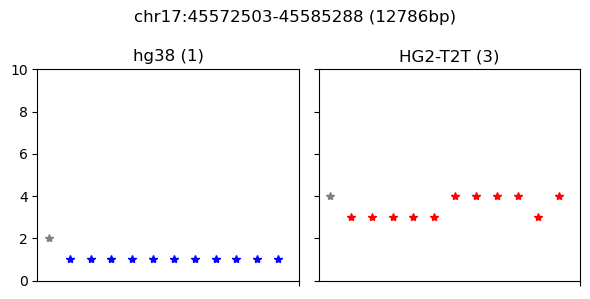

In [322]:
# This pair-wise alignment result is suggesting the pos of DUP is further than DRAGEN's result by 357bp
# I want to check the bin_alignment results of before and after the basepair level correction
plot_single_bin_alignment('chr17:45572503-45585288')

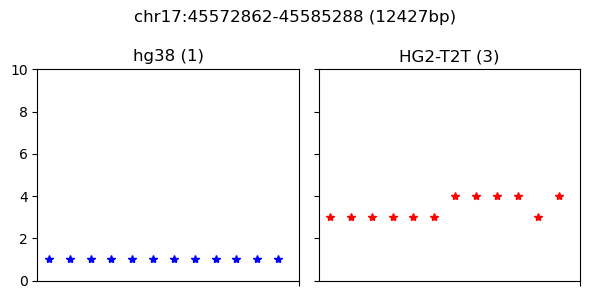

In [321]:
plot_single_bin_alignment(f'chr17:{45572503+359}-45585288')

In [330]:
# Test another DUP that over-estimated its interval size
check_pairwise_alignment('chr12:79757409-79768989')

Alignment Interval: chr12_MATERNAL:79989392-80000971, Strand: 1
Alignment Score: 23139.0
Alignment Start: 0, End: 11584
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79947757-79959333, Strand: 1
Alignment Score: 23134.0
Alignment Start: 0, End: 11583
--------------------------------------------


In [332]:
bin_alignment('chr12:79757409-79768989')

(['chr12:79757409-79758409',
  'chr12:79758409-79759409',
  'chr12:79759409-79760409',
  'chr12:79760409-79761409',
  'chr12:79761409-79762409',
  'chr12:79762409-79763409',
  'chr12:79763409-79764409',
  'chr12:79764409-79765409',
  'chr12:79765409-79766409',
  'chr12:79766409-79767409',
  'chr12:79767409-79768409'],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3])

In [343]:
neutral_sliding_window_list = []
gain_sliding_window_list = []
sliding_window_interval_list, sliding_window_hg38_hit_list, sliding_window_hg2_hit_list = bin_alignment('chr12:79757409-79768989')
for i in sliding_window_interval_list:
    if sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)]*2 >= sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)]: 
        print(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)])
        neutral_sliding_window_list.append(i)
    else:
        print(i, sliding_window_hg38_hit_list[sliding_window_interval_list.index(i)], sliding_window_hg2_hit_list[sliding_window_interval_list.index(i)])
        gain_sliding_window_list.append(i)

chr12:79757409-79758409 1 2
chr12:79758409-79759409 1 2
chr12:79759409-79760409 1 2
chr12:79760409-79761409 1 2
chr12:79761409-79762409 1 3
chr12:79762409-79763409 1 3
chr12:79763409-79764409 1 3
chr12:79764409-79765409 1 3
chr12:79765409-79766409 1 3
chr12:79766409-79767409 1 3
chr12:79767409-79768409 1 3


In [351]:
# Create a new interval that is the union of the last copy neutral interval and the first gain interval
stitched_interval = ip.create_interval(ip.parse_interval(gain_sliding_window_list[-1])[0], ip.parse_interval(neutral_sliding_window_list[-1])[1], ip.parse_interval(gain_sliding_window_list[0])[-1])

In [352]:
v.align_interval(stitched_interval, ReferenceLocations.hg38, hg38, hg002t2t)

([['chr12:79760408-79762409', 1]],
 [['chr12_MATERNAL:79992391-79994392', 1],
  ['chr12_PATERNAL:79950756-79952755', 1],
  ['chr12_PATERNAL:79959150-79960631', 1]])

In [353]:
# Check pairwise alignment of the stitched interval
check_pairwise_alignment(stitched_interval)

Alignment Interval: chr12_MATERNAL:79992391-79994392, Strand: 1
Alignment Score: 3998.0
Alignment Start: 0, End: 2002
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79950756-79952755, Strand: 1
Alignment Score: 3992.5
Alignment Start: 0, End: 2002
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79959150-79960631, Strand: 1
Alignment Score: 2865.0
Alignment Start: 511, End: 2004
--------------------------------------------


In [354]:
stitched_interval

'chr12:79760409-79762409'

In [355]:
corrected_interval = f'chr12:{79760409+511}-79762409'
check_pairwise_alignment(corrected_interval)

Alignment Interval: chr12_MATERNAL:79992902-79994392, Strand: 1
Alignment Score: 2976.0
Alignment Start: 0, End: 1491
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79951267-79952755, Strand: 1
Alignment Score: 2970.5
Alignment Start: 0, End: 1491
--------------------------------------------
Alignment Interval: chr12_PATERNAL:79959150-79960631, Strand: 1
Alignment Score: 2865.0
Alignment Start: 0, End: 1493
--------------------------------------------


In [356]:
corrected_interval

'chr12:79760920-79762409'